In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from graph_tool.all import *

In [2]:
edgelist = pd.read_csv('../data/edgelist_dec3_cluAgglomerative550.txt', sep='\t')

In [3]:
edgelist.head()

,time_begin,time_end,cluster_id_begin,cluster_id_end,type,speed
0,2015-11-04 10:12:28,2015-11-04 11:06:35,0,0,foot,0.64
1,2015-11-04 11:06:35,2015-11-04 11:06:43,0,0,car,785.12
2,2015-11-04 12:56:46,2015-11-04 12:57:59,0,0,foot,2.59
3,2015-11-04 12:57:59,2015-11-04 13:11:34,0,0,foot,1.95
4,2015-11-04 11:55:18,2015-11-04 12:10:44,0,0,foot,0.41


In [4]:
edgelist_ = edgelist[['cluster_id_begin', 'cluster_id_end']]

In [5]:
edgelist_.head()

,cluster_id_begin,cluster_id_end
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [6]:
edgelist_weight = edgelist_.groupby(['cluster_id_begin', 'cluster_id_end']).size().reset_index()
edgelist_weight.rename(columns={0:'weight'}, inplace=True)
edgelist_weight['weight'] = edgelist_weight['weight']/100+1

In [7]:
edgelist_weight.head()

,cluster_id_begin,cluster_id_end,weight
0,0,0,29.75
1,0,1,6.59
2,0,3,3.64
3,0,4,1.39
4,0,10,3.62


Create empty graph:

In [8]:
g = Graph(directed=True)

Add edges from list:

In [9]:
g.add_edge_list(edgelist_weight[['cluster_id_begin', 'cluster_id_end']].values)

Plot graph:

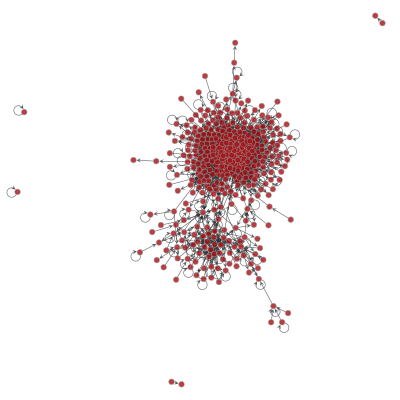

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fe5c7dba6a0, at 0x7fe5e8129a20>

In [10]:
graph_draw(g, output_size=(400, 400))

Create edge property map called <font face='Courier'>weight</font> (https://stackoverflow.com/questions/45821741/how-to-add-properties-to-edges-when-using-add-edge-list-in-graph-tool):

In [11]:
weight = g.new_edge_property('int')

Add weights to edges:

In [12]:
g.add_edge_list(edgelist_weight.values, eprops=[weight])

Plot again, now using edge weights as widths:

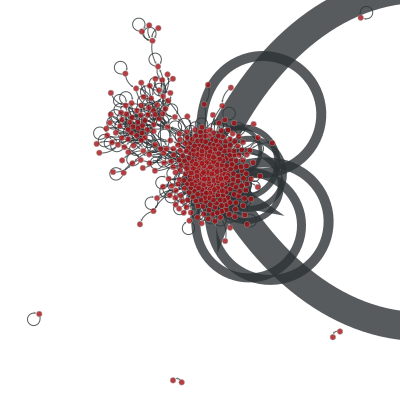

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fe5c7dba6a0, at 0x7fe5d47d1828>

In [13]:
graph_draw(g, output_size=(400, 400), edge_pen_width=weight)

Graph properties:

In [14]:
print(g)

<Graph object, directed, with 419 vertices and 7110 edges at 0x7fe5c7dba6a0>


## Stochastic Blockmodeling

### Unnested Blockmodel

In [15]:
state_ndc = minimize_blockmodel_dl(g, deg_corr=False)
state_dc = minimize_blockmodel_dl(g, deg_corr=True)

Model selection:

In [16]:
state_dc.entropy()-state_ndc.entropy() # degree-corrected model is better

-1174.4072327412687

Description:

In [17]:
print(state_dc)

<BlockState object with 29 blocks (29 nonempty), degree-corrected, for graph <Graph object, directed, with 419 vertices and 7110 edges at 0x7fe5c7dba6a0>, at 0x7fe5d47f1518>


Plot:

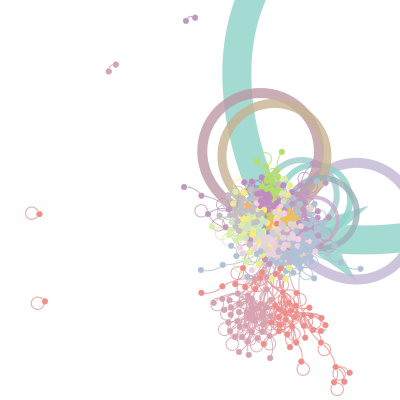

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fe5c7dba6a0, at 0x7fe5c7dba390>

In [18]:
state_dc.draw(output_size=(400, 400), edge_pen_width=weight)

Group memberships:

In [19]:
b = state_dc.get_blocks()
b.a[42] # membership of node 42

4

Matrix of edge counts:

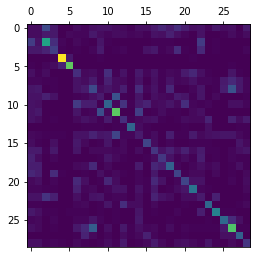

In [20]:
e = state_dc.get_matrix()
plt.matshow(e.todense())

### Nested Blockmodel

In [21]:
state_nested_ndc = minimize_nested_blockmodel_dl(g, deg_corr=False)
state_nested_dc = minimize_nested_blockmodel_dl(g, deg_corr=True)

In [22]:
state_nested_dc.entropy()-state_nested_ndc.entropy() # degree-corrected model is better

-769.8971329029482

In [23]:
print(state_nested_dc)

<NestedBlockState object, with base <BlockState object with 46 blocks (46 nonempty), degree-corrected, for graph <Graph object, directed, with 419 vertices and 7110 edges at 0x7fe5c7dba6a0>, at 0x7fe5d4727a20>, and 4 levels of sizes [(419, 46), (46, 12), (12, 3), (3, 1)] at 0x7fe5d4719198>


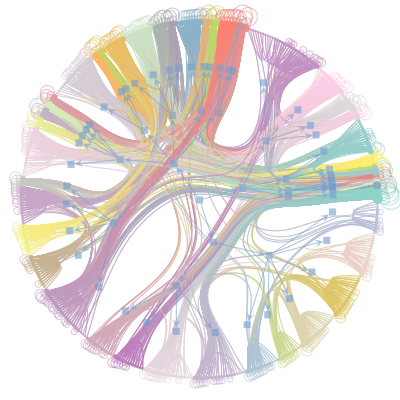

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fe5c7dba6a0, at 0x7fe5d4800518>,
 <Graph object, directed, with 481 vertices and 480 edges at 0x7fe5d476c1d0>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fe5d476c1d0, at 0x7fe5d4719c88>)

In [24]:
state_nested_dc.draw(output_size=(400, 400))

Summarize hierarchy:

In [25]:
state_nested_dc.print_summary()

l: 0, N: 419, B: 46
l: 1, N: 46, B: 12
l: 2, N: 12, B: 3
l: 3, N: 3, B: 1


Group memberships at given level:

In [26]:
levels = state_nested_dc.get_levels()
for s in levels:
    print(s)

<BlockState object with 46 blocks (46 nonempty), degree-corrected, for graph <Graph object, directed, with 419 vertices and 7110 edges at 0x7fe5c7dba6a0>, at 0x7fe5d4727a20>
<BlockState object with 12 blocks (12 nonempty), for graph <Graph object, directed, with 46 vertices and 848 edges at 0x7fe5d4727fd0>, at 0x7fe5d46eaf28>
<BlockState object with 3 blocks (3 nonempty), for graph <Graph object, directed, with 12 vertices and 125 edges at 0x7fe5d46ea208>, at 0x7fe5d47197f0>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, directed, with 3 vertices and 9 edges at 0x7fe5d46cf2e8>, at 0x7fe5d4747e48>


In [27]:
r = levels[0].get_blocks()[42]    # group membership of node 42 in level 0
print(r)
r = levels[0].get_blocks()[r]     # group membership of node 42 in level 1
print(r)
r = levels[0].get_blocks()[r]     # group membership of node 42 in level 2
print(r)
r = levels[0].get_blocks()[r]     # group membership of node 42 in level 3
print(r)

25
16
8
4


### Edge Weights

Internalize edge property map:

In [28]:
eprop = g.new_edge_property('float')
g.edge_properties['weight'] = eprop

In [29]:
g.list_properties()

weight         (edge)    (type: double)


In [30]:
state_weighted = minimize_blockmodel_dl(g, state_args=dict(recs=[g.ep.weight], rec_types=['real-exponential']), deg_corr=True)

KeyboardInterrupt: 

In [ ]:
state_weighted.draw(output_size=(400, 400), edge_pen_width=weight)